In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas

In [2]:
def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peaks:
        if peak.isSelected():
            merged.addPeak(nsx.PeakCalc(peak))
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def predict_peaks(data):
    predictor = nsx.PeakPredictor()
    predictor._dmin = 2.1
    predictor._dmax = 50.0
    predictor._searchRadius = 100.0
    predictor._peakScale = 1.0
    predictor._bkgScale = 3.0
    predictor._handler = nsx.ProgressHandler()
    predictor.addPredictedPeaks(data)
    
def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)
            
def get_uc_parameters(uc):
    u = uc.getAVector()
    v = uc.getBVector()
    w = uc.getCVector()
    
    a = np.linalg.norm(u)
    b = np.linalg.norm(v)
    c = np.linalg.norm(w)
    
    alpha = math.acos(v.transpose().dot(w) / b / c) / math.pi * 180.0
    beta = math.acos(u.transpose().dot(w) / a / c) / math.pi * 180.0
    gamma = math.acos(u.transpose().dot(v) / a / b) / math.pi * 180.0
    
    return a, b, c, alpha, beta, gamma


def index_peak(a,b,c, peak, tolerance):
    h = peak.getQ().dot(a).trace()
    k = peak.getQ().dot(b).trace()
    l = peak.getQ().dot(c).trace()
    
    dh = h-round(h)
    dk = k-round(k)
    dl = l-round(l)
    
    hkl = np.array([[round(h), round(k), round(l)]], dtype=float)
    
    return math.sqrt(dh**2 + dk**2 + dl**2) < tolerance, hkl


def percent_indexed(uc, peaks):
    num_index = 0
    
    a = uc.getAVector()
    b = uc.getBVector()
    c = uc.getCVector()
    
    for peak in peaks:
        success, hkl = index_peak(a,b,c,peak,0.2)
        if success:
            num_index += 1
            
    return 100.0 * num_index / len(peaks)

In [3]:
import glob
numor_names = []

for file in glob.glob("/home/jonathan/data/d19/d19_reference_data/*.h5"):
    numor_names.append(file)
    print(file)

/home/jonathan/data/d19/d19_reference_data/125622.h5
/home/jonathan/data/d19/d19_reference_data/125562.h5
/home/jonathan/data/d19/d19_reference_data/125579.h5
/home/jonathan/data/d19/d19_reference_data/125623.h5
/home/jonathan/data/d19/d19_reference_data/125571.h5
/home/jonathan/data/d19/d19_reference_data/125574.h5
/home/jonathan/data/d19/d19_reference_data/125570.h5
/home/jonathan/data/d19/d19_reference_data/125627.h5
/home/jonathan/data/d19/d19_reference_data/125618.h5
/home/jonathan/data/d19/d19_reference_data/125630.h5
/home/jonathan/data/d19/d19_reference_data/125566.h5
/home/jonathan/data/d19/d19_reference_data/125578.h5
/home/jonathan/data/d19/d19_reference_data/125626.h5
/home/jonathan/data/d19/d19_reference_data/125619.h5
/home/jonathan/data/d19/d19_reference_data/125580.h5
/home/jonathan/data/d19/d19_reference_data/125615.h5
/home/jonathan/data/d19/d19_reference_data/125567.h5
/home/jonathan/data/d19/d19_reference_data/125563.h5
/home/jonathan/data/d19/d19_reference_data/125

In [4]:
expt = nsx.Experiment('d19_reference', 'D19')
d19 = expt.getDiffractometer()
numors = nsx.vector_data()

for numor in numor_names:
    reader = nsx.HDF5DataReader(numor, d19)
    data = nsx.DataSet(reader, d19)
    expt.addData(data)
    numors.push_back(data)


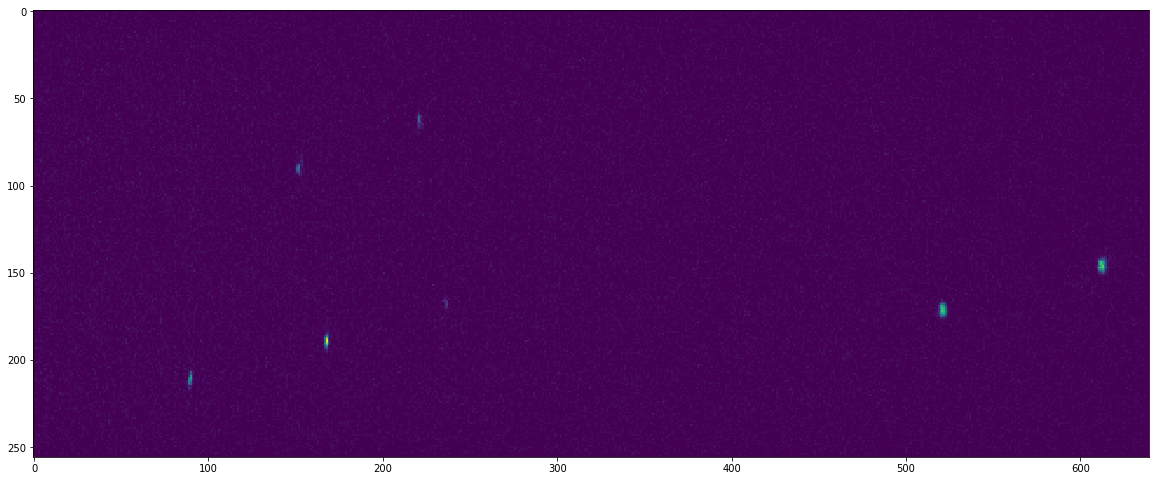

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(numors[0].getFrame(0))
plt.show()

In [6]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [7]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setConfidence(0.997)
finder.setThresholdType(1)
finder.setThresholdValue(0.35)
#finder.setThresholdValue(1.00)
finder.setKernel(kernel)

In [8]:
finder.find(numors)
peaks = []

for numor in numors:
    numor_peaks = numor.getPeaks()
    peaks.extend(numor_peaks)
    

In [9]:
print(len(peaks))

5943


In [18]:
I = 0.0
I2 = 0.0

for peak in peaks:
    intensity = peak.getCorrectedIntensity().getValue()
    I += intensity
    I2 += intensity**2
    
I /= len(peaks)

variance = (I2 - len(peaks)*I*I) / (len(peaks)-1)
std = math.sqrt(variance)

print("average intensity =", I)
print("std intensity     =", std)

average intensity = 7045.010881554479
std intensity     = 11409.559023112084


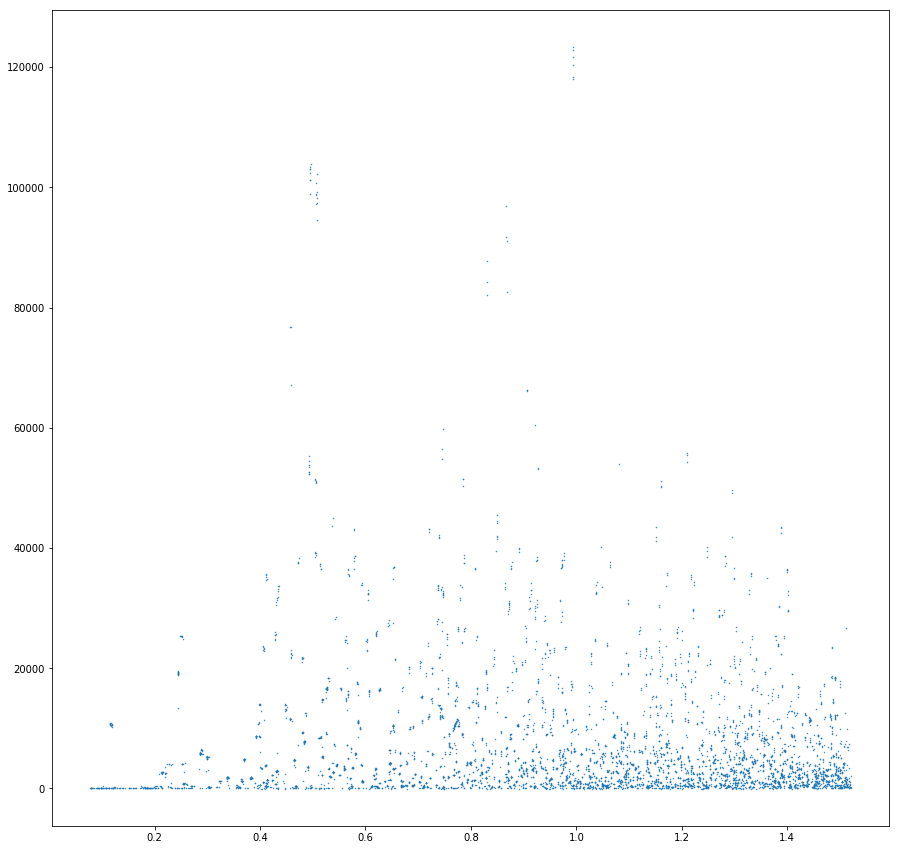

In [19]:
I = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().getValue())
    q.append(np.linalg.norm(peak.getQ()))

plt.figure(figsize=(15,15))
plt.scatter(q, I, s=0.2)
plt.show()

In [10]:
indexer = nsx.AutoIndexer(expt, nsx.ProgressHandler())

num_to_index = 0

for peak in peaks:
    d = 1.0 / np.linalg.norm(peak.getQ())
    if peak.isSelected() and peak.getCorrectedIntensity().getValue() > 500.0:
        indexer.addPeak(peak)
        num_to_index += 1

print("indexing", num_to_index, "peaks")
        
params = nsx.IndexerParameters()

handler = nsx.ProgressHandler()
indexer.autoIndex(params)

solutions = indexer.getSolutions()

indexing 4687 peaks


In [11]:
for soln in solutions:
    uc = soln[0]
    quality = soln[1]

    a,b,c,alpha,beta,gamma = get_uc_parameters(uc)
    
    print("{:7.3f}    {:7.3f}    {:7.3f}    {:7.3f}    {:7.3f}    {:7.3f}    {:7.3f}".format(a, b, c, alpha, beta, gamma, soln[1]))



 11.154      5.545     16.180     90.017     96.415     90.048     99.808
  7.868     12.409     16.180     92.891     94.531    108.154     99.808
  5.577     16.637     17.106    108.938     96.052     90.040     99.808
  7.868     12.412     16.180     92.874     94.539    108.162     99.808
  7.868     12.412     16.180     92.874     94.539    108.162     99.808
 11.155     11.092     16.516     89.990     76.810     89.955     99.808
 12.411     16.515     17.629     77.480     81.675     84.144     99.808
  5.577     11.090     17.102     71.096     83.917     89.951     99.787
  7.863     12.422     17.124     70.364     81.212     71.869     99.787
  7.863     16.182     20.038     93.556    100.988     94.564     99.787
 17.555     17.623     17.120     89.920    109.863     89.774     99.787
 12.453     17.103     20.036    109.142     97.419     92.832     99.765
 19.646      5.547     19.902    123.804     70.669     55.561     99.701
 22.310     11.094     20.669     89.9

In [12]:
uc = solutions[2][0]
u = uc.getAVector() / 2.0
v = uc.getBVector()
w = uc.getCVector()

new_uc = nsx.UnitCell.fromDirectVectors(u,v,w)
print(percent_indexed(uc, peaks))

93.23573952549218


In [13]:
a = uc.getAVector()
b = uc.getBVector()
c = uc.getCVector()

print(uc)

num_peaks = 0

for peak in peaks:
    if not peak.isSelected():
        continue
        
    success, hkl = index_peak(a,b,c, peak, 0.2)
    if success:
        peak.addUnitCell(uc, True)
        num_peaks += 1
        
print(num_peaks)

<pynsx.UnitCell; proxy of <Swig Object of type 'std::shared_ptr< nsx::UnitCell > *' at 0x7f3fe139ac00> >
5433


In [14]:
compute_statistics(peaks, nsx.SpaceGroup("P 21"), False)

{'CChalf': 0.8332801982178477,
 'CCtrue': 0.9534460082171076,
 'Rmeas': 0.7388346957609327,
 'Rmerge': 0.6083607872965405,
 'Rpim': 0.4024394735444777}

In [18]:
hs = []
ks = []
ls = []
error = []
frame = []

for peak in peaks:
    if not peak.isSelected():
        continue
    
    center = peak.getShape().getAABBCenter().transpose()[0]
    
    q = peak.getQ()
    hkl = peak.getMillerIndices()[0]
    
    #puc = peak.activeUnitCell()
    g = uc.getMetricTensor()
    
    real_hkl = uc.fromReciprocalStandard(q)[0]
    
    d = real_hkl-hkl
    
    if (np.linalg.norm(d) > 0.5):
        continue
    
    #print(hkl)
    #print(real_hkl)
    
    hs.append(d[0])
    ks.append(d[1])
    ls.append(d[2])
    error.append(np.linalg.norm(d))
    frame.append(center[2])


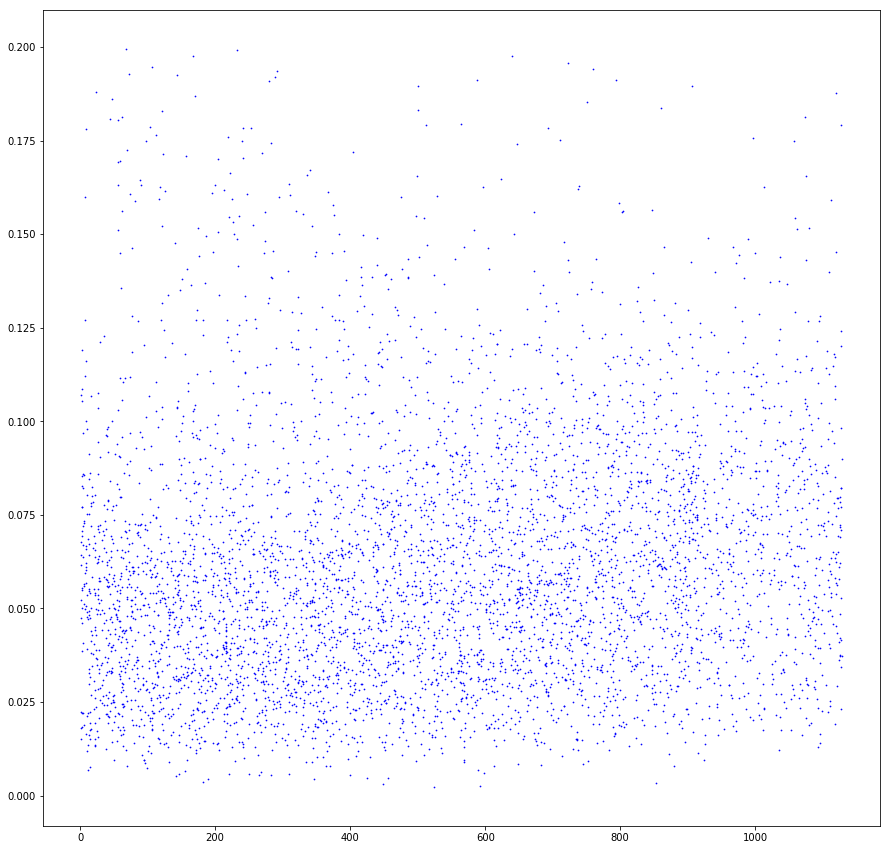

In [19]:
plt.figure(figsize=(15,15))
#plt.scatter(frame, hs, s=0.5, color='r')
#plt.scatter(frame, ks, s=0.5, color='g')
#plt.scatter(frame, ls, s=0.5, color='b')
plt.scatter(frame, error, s=0.5, color='b')
plt.show()